In [148]:
"""
from tikzplotlib import write_tikz

write_tikz(louvain_graph, "graph_tikz.tex", caption="An example of a complete graph with 5 nodes.", theme="default")
"""

'\nfrom tikzplotlib import write_tikz\n\nwrite_tikz(louvain_graph, "graph_tikz.tex", caption="An example of a complete graph with 5 nodes.", theme="default")\n'

In [149]:
import geopandas as gpd
import networkx as nx
from importlib import reload
import pandas as pd
pd.set_option('display.float_format', '{:.2f}'.format)

import lib.utils as utils
reload(utils)
import lib.scoring as scoring
reload(scoring)
import lib.gnn as gnn
reload(gnn)
import lib.property_weights as weights
reload(weights)
import lib.algorithms as algorithms
reload(algorithms)
import lib.simulation as sim
reload(sim)

<module 'lib.simulation' from '/Users/hugoschwabe/Documents/Code/bachelor-thesis/lib/simulation.py'>

# Initialize NUTS Regions

In [44]:
nuts3 = gpd.read_file("./data//NUTS3/NUTS_RG_20M_2024_4326.shp").set_index("NUTS_ID")
nuts3 = nuts3[nuts3["LEVL_CODE"] == 3]
nuts3 = nuts3.to_crs("EPSG:4326")
nuts3 = nuts3.reset_index()
nuts3.head(3)

NUTS_ID  LEVL_CODE CNTR_CODE NAME_LATN NUTS_NAME  MOUNT_TYPE  URBN_TYPE  \
0   AL011          3        AL     Dibër     Dibër         NaN        NaN   
1   AL012          3        AL    Durrës    Durrës         NaN        NaN   
2   AL013          3        AL     Kukës     Kukës         NaN        NaN   

   COAST_TYPE                                           geometry  
0         NaN  POLYGON ((20.2208 41.86937, 20.56287 41.84614,...  
1         NaN  POLYGON ((19.55733 41.57767, 19.83218 41.56823...  
2         NaN  POLYGON ((20.59429 41.87733, 20.56287 41.84614...

# Initialization

##### Process Full Graph

In [154]:
G = nx.read_gml("./data/de_cs_virtual_edge.gml")

original = utils.convert_to_digraph(G)
utils.add_capacity(original)
utils.add_norm_capacity(original)
#utils.add_dummy_supply(original, throughput=5000)
utils.add_supply_from_csv(original, "./data/de_cs_virtual_edge_flow.csv", verbose=True)

Updated 'supply' attribute for 3578 nodes based on CSV data.


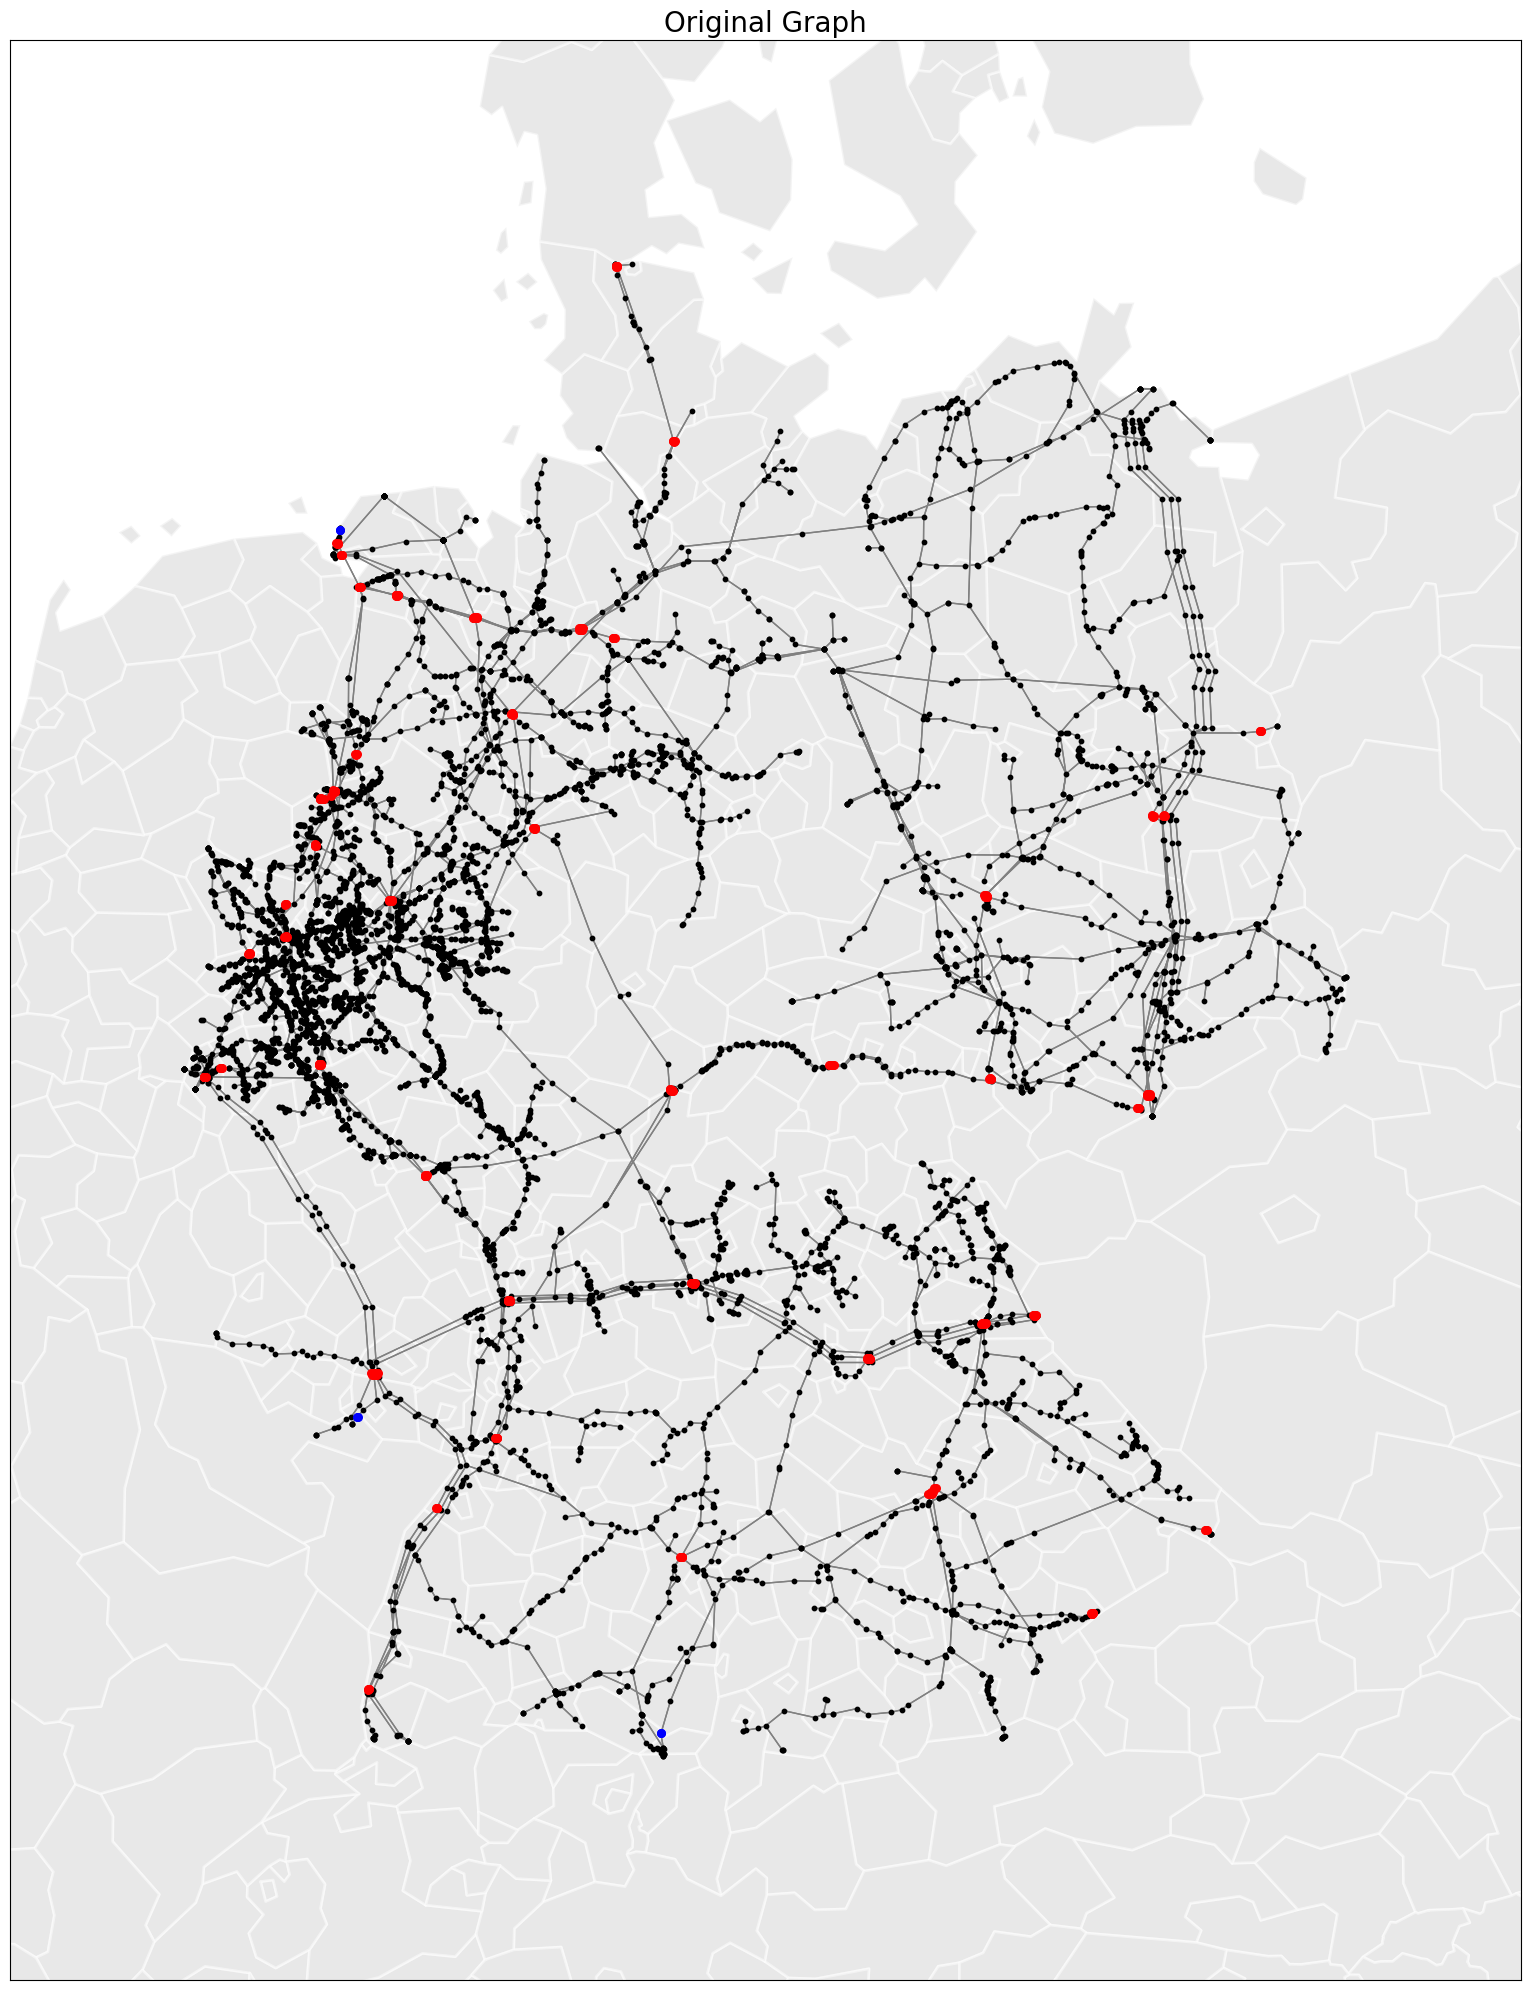

In [153]:
utils.plot_network(
	original,
	gdf=nuts3.to_crs("EPSG:3035"),
	title="Original Graph",
	nodes=False
)

##### Calculating Weights for Properties Score

In [47]:
"""print(f"Network has {original.number_of_nodes()} nodes and {original.number_of_edges()} edges")
final_scores = weights.calculate_node_type_importance(original)"""

'print(f"Network has {original.number_of_nodes()} nodes and {original.number_of_edges()} edges")\nfinal_scores = weights.calculate_node_type_importance(original)'

In [48]:
property_weights = weights.aggregate_results(pd.read_csv("data/detailed_property_weights.csv"))
property_weights = property_weights["norm_avg_importance_score"].to_dict()
property_weights

{'BIO': 1.0,
 'GPR': 0.7689624728357662,
 'CV': 0.49238163862272694,
 'LNG': 0.3101344418784876,
 'CS': 0.23572140435307978,
 'IC': 0.17410202804388877,
 'TPP': 0.08055997117332092,
 'X': 0.06163355640080082,
 'DSO': 0.041068455243452456,
 'ST': 0.017802578088449105,
 'IND': 0.015504007418196925}

# Run the Algorithms

In [49]:
original_score = scoring.score(
	original, 
	original, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
original_score

nodes_score: 0.0
edges_score: 0.0
pre_cyclo: 983
post_cyclo: 983
cyclomatic_score: 0
complexity_score: 0.0

pdiv_score: 1.0
emd_score: 0.96176557350605
spectral_dist_score: 1.0
structure_score: 0.9872551911686833

original_regions: 341
simplified_regions: 341
regionality_score: 1.0

original_properties: 428717.17167103756
simplified_properties: 428717.17167103756
properties_score: 1.0

Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 4943.232812280533 kg/s
max_dev_error: 0.0
flow_score: 1.0

Overall Weighted Score: 0.7974510382337368


np.float64(0.7974510382337368)

In [146]:
utils.plot_network_pyvis(original, "Original Graph", "./plots/original.html")

./plots/original.html
Interactive graph saved to './plots/original.html'


In [50]:
"""
nodes_score: 0.0
edges_score: 0.0
pre_cyclo: 760
post_cyclo: 760
cyclomatic_score: 0
complexity_score: 0.0

ac_simplified: 0.0001178643842265943
ac_original: 0.00011786438424365008
ac_score: 0.9999999999276467
emd_score: 0.9853292048517621
spectral_dist_score: 1.0
structure_score: 0.9951097349264696

original_regions: 344
simplified_regions: 344
regionality_score: 1.0

original_properties: 6022.75
simplified_properties: 6022.75
properties_score: 1.0

Overall Score: 0.7487774337316174
"""

'\nnodes_score: 0.0\nedges_score: 0.0\npre_cyclo: 760\npost_cyclo: 760\ncyclomatic_score: 0\ncomplexity_score: 0.0\n\nac_simplified: 0.0001178643842265943\nac_original: 0.00011786438424365008\nac_score: 0.9999999999276467\nemd_score: 0.9853292048517621\nspectral_dist_score: 1.0\nstructure_score: 0.9951097349264696\n\noriginal_regions: 344\nsimplified_regions: 344\nregionality_score: 1.0\n\noriginal_properties: 6022.75\nsimplified_properties: 6022.75\nproperties_score: 1.0\n\nOverall Score: 0.7487774337316174\n'

##### Community Detection

In [152]:
greedy_modularity_results, greedy_modularity_graph = algorithms.greedy_modularity_communities(original)
greedy_modularity_score = scoring.score(
	original, 
	greedy_modularity_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
greedy_modularity_score

Gefundene Communities: 88
Modularität Q = 0.9458345014415319
nodes_score: 0.9883149648121099
edges_score: 0.9800305415247269
pre_cyclo: 983
post_cyclo: 83
cyclomatic_score: 0.9155645981688708
complexity_score: 0.9613033681685691

pdiv_score: 0.051845724475907407
emd_score: 0.6654596582483985
spectral_dist_score: 0.3695533582257581
structure_score: 0.3622862469833546

original_regions: 341
simplified_regions: 74
regionality_score: 0.21700879765395895

original_properties: 428717.17167103756
simplified_properties: 8987.479023063459
properties_score: 0.020963655334896907

Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 6230.571237298724 kg/s
max_dev_error: 0.26042439713137533
flow_score: 0.7395756028686247

Overall Weighted Score: 0.4602275342018809


np.float64(0.4602275342018809)

In [151]:
"""
Gefundene Communities: 88
Modularität Q = 0.9458345014415319

nodes_score: 0.9883149648121099
edges_score: 0.9800305415247269
pre_cyclo: 983
post_cyclo: 83
cyclomatic_score: 0.9155645981688708
complexity_score: 0.9613033681685691

pdiv_score: 0.051845724475907407
emd_score: 0.6654596582483985
spectral_dist_score: 0.3695533582257581
structure_score: 0.3622862469833546

original_regions: 341
simplified_regions: 74
regionality_score: 0.21700879765395895

original_properties: 428717.17167103756
simplified_properties: 8987.479023063459
properties_score: 0.020963655334896907

Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 6230.571237298724 kg/s
max_dev_error: 0.26042439713137533
flow_score: 0.7395756028686247

Overall Weighted Score: 0.4602275342018809
"""

'\nGefundene Communities: 88\nModularität Q = 0.9458345014415319\n\nnodes_score: 0.9883149648121099\nedges_score: 0.9800305415247269\npre_cyclo: 983\npost_cyclo: 83\ncyclomatic_score: 0.9155645981688708\ncomplexity_score: 0.9613033681685691\n\npdiv_score: 0.051845724475907407\nemd_score: 0.6654596582483985\nspectral_dist_score: 0.3695533582257581\nstructure_score: 0.3622862469833546\n\noriginal_regions: 341\nsimplified_regions: 74\nregionality_score: 0.21700879765395895\n\noriginal_properties: 428717.17167103756\nsimplified_properties: 8987.479023063459\nproperties_score: 0.020963655334896907\n\nOriginal Deliverability: 4943.232812280533 kg/s\nSimplified Deliverability: 6230.571237298724 kg/s\nmax_dev_error: 0.26042439713137533\nflow_score: 0.7395756028686247\n\nOverall Weighted Score: 0.4602275342018809\n'

In [53]:
louvain_results, louvain_graph = algorithms.louvain_communities(
	original,
	["CS", "CV", "IC"]
)
louvain_score = scoring.score(
	original, 
	louvain_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
louvain_score

Gefundene Communities: 71
Modularität Q = 0.946981750770434
nodes_score: 0.9905723011552251
edges_score: 0.9817925525666628
pre_cyclo: 983
post_cyclo: 85
cyclomatic_score: 0.91353001017294
complexity_score: 0.9619649546316094

pdiv_score: 0.04677037456045552
emd_score: 0.7837638564078475
spectral_dist_score: 0.36941485497153087
structure_score: 0.3999830286466113

original_regions: 341
simplified_regions: 59
regionality_score: 0.17302052785923755

original_properties: 428717.17167103756
simplified_properties: 8850.856225007912
properties_score: 0.020644977178099443

Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 7012.682172386787 kg/s
max_dev_error: 0.41864290813192045
flow_score: 0.5813570918680795

Overall Weighted Score: 0.4273941160367275


np.float64(0.4273941160367275)

In [147]:
utils.plot_network_pyvis(louvain_graph, "Louvain Communities Graph", "./plots/louvain_communities.html")

./plots/louvain_communities.html
Interactive graph saved to './plots/louvain_communities.html'


In [54]:
"""
Gefundene Communities: 217
Modularität Q = 0.9321190871193424

nodes_score: 0.9725177304964538
edges_score: 0.9577123050259966
pre_cyclo: 760
post_cyclo: 150
cyclomatic_score: 0.8026315789473684
complexity_score: 0.9109538714899396

ac_simplified: 0.02177046889260202
ac_original: 2.943008814961269e-06
ac_score: 0.0002703305139576395
emd_score: 0.8258434352182826
spectral_dist_score: 0.36903329410498675
structure_score: 0.39838235327907573

original_regions: 344
simplified_regions: 135
regionality_score: 0.39244186046511625

original_properties: 893244.1248992208
simplified_properties: 2604.549255382928
properties_score: 0.002915831386718366

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1898.84 kg/s
max_dev_error: 0.1576940027048441
flow_score: 0.8423059972951559

Overall Weighted Score: 0.5093999827832012
"""

'\nGefundene Communities: 217\nModularität Q = 0.9321190871193424\n\nnodes_score: 0.9725177304964538\nedges_score: 0.9577123050259966\npre_cyclo: 760\npost_cyclo: 150\ncyclomatic_score: 0.8026315789473684\ncomplexity_score: 0.9109538714899396\n\nac_simplified: 0.02177046889260202\nac_original: 2.943008814961269e-06\nac_score: 0.0002703305139576395\nemd_score: 0.8258434352182826\nspectral_dist_score: 0.36903329410498675\nstructure_score: 0.39838235327907573\n\noriginal_regions: 344\nsimplified_regions: 135\nregionality_score: 0.39244186046511625\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 2604.549255382928\nproperties_score: 0.002915831386718366\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1898.84 kg/s\nmax_dev_error: 0.1576940027048441\nflow_score: 0.8423059972951559\n\nOverall Weighted Score: 0.5093999827832012\n'

In [62]:
k_means_results, k_means_graph= algorithms.k_means(original)
k_means_score = scoring.score(
	original, 
	k_means_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
k_means_score


---> Optimal k found: 230 with score 0.4842 <---

Clustering 7531 nodes into 230 communities based on location...
Clustering complete.
Geographic Clustering Finished. Found 230 communities

nodes_score: 0.9694595671225601
edges_score: 0.9541877129096675
pre_cyclo: 983
post_cyclo: 161
cyclomatic_score: 0.8362156663275686
complexity_score: 0.9199543154532653

pdiv_score: 0.15917849036345078
emd_score: 0.8165130151524018
spectral_dist_score: 0.3726038010280269
structure_score: 0.4494317688479598

original_regions: 341
simplified_regions: 184
regionality_score: 0.5395894428152492

original_properties: 428717.17167103756
simplified_properties: 30779.871658356828
properties_score: 0.07179528531218894

Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 6954.466562716493 kg/s
max_dev_error: 0.4068660787004464
flow_score: 0.5931339212995537

Overall Weighted Score: 0.5147809467456435


np.float64(0.5147809467456435)

In [63]:
"""
---> Optimal k found: 250 with score 0.4826 <---

nodes_score: 0.968338399189463
edges_score: 0.9500866551126517
pre_cyclo: 760
post_cyclo: 183
cyclomatic_score: 0.7592105263157894
complexity_score: 0.8925451935393013

ac_simplified: 0.010202485617694
ac_original: 2.9430090599643724e-06
ac_score: 0.0005767536411452889
emd_score: 0.8372819143130268
spectral_dist_score: 0.3701622364699395
structure_score: 0.40267363480803714

original_regions: 344
simplified_regions: 183
regionality_score: 0.5319767441860465

original_properties: 893244.1248992208
simplified_properties: 4606.742044261168
properties_score: 0.005157315806337846

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 2381.45 kg/s
max_dev_error: 0.05638360537654309
flow_score: 0.9436163946234569

Overall Weighted Score: 0.555193856592636
"""

'\n---> Optimal k found: 250 with score 0.4826 <---\n\nnodes_score: 0.968338399189463\nedges_score: 0.9500866551126517\npre_cyclo: 760\npost_cyclo: 183\ncyclomatic_score: 0.7592105263157894\ncomplexity_score: 0.8925451935393013\n\nac_simplified: 0.010202485617694\nac_original: 2.9430090599643724e-06\nac_score: 0.0005767536411452889\nemd_score: 0.8372819143130268\nspectral_dist_score: 0.3701622364699395\nstructure_score: 0.40267363480803714\n\noriginal_regions: 344\nsimplified_regions: 183\nregionality_score: 0.5319767441860465\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 4606.742044261168\nproperties_score: 0.005157315806337846\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 2381.45 kg/s\nmax_dev_error: 0.05638360537654309\nflow_score: 0.9436163946234569\n\nOverall Weighted Score: 0.555193856592636\n'

##### Community Detection in Attributed Graphs

In [65]:
gnn_results, gnn_graph = algorithms.gnn_clustering(
	original,
	coord_weight=200
)
gnn_score = scoring.score(
	original, 
	gnn_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
gnn_score


--- Starting GNN Model Training ---

--- Finding Optimal Hyperparameters (k and coord_weight) ---

Testing Coordinate Weight: 0.5

Testing Coordinate Weight: 1.0

Testing Coordinate Weight: 2.0

Testing Coordinate Weight: 5.0

Testing Coordinate Weight: 10.0

---> Optimal Hyperparameters Found <---
  - Best Coordinate Weight: 10.0
  - Best Number of Clusters (k): 250
  - With Silhouette Score: 0.3116
Clustering 7531 nodes using combined features (Embeddings + Coords)...
Clustering complete.
nodes_score: 0.9668038773071306
edges_score: 0.8951016093034183
pre_cyclo: 983
post_cyclo: 644
cyclomatic_score: 0.34486266531027465
complexity_score: 0.735589383973608

pdiv_score: 0.050610679061865116
emd_score: 0.8529891711587044
spectral_dist_score: 0.3721992575782391
structure_score: 0.42526636926626954

original_regions: 341
simplified_regions: 143
regionality_score: 0.41935483870967744

original_properties: 428717.17167103756
simplified_properties: 49911.0174922794
properties_score: 0.116419

np.float64(0.46323525296805884)

In [ ]:
"""
---> Optimal Hyperparameters Found <---
  - Best Coordinate Weight: 10.0
  - Best Number of Clusters (k): 250
  - With Silhouette Score: 0.3121

Clustering 7896 nodes using combined features (Embeddings + Coords)...
Clustering complete.
nodes_score: 0.968338399189463
edges_score: 0.8972848064702484
pre_cyclo: 760
post_cyclo: 640
cyclomatic_score: 0.1578947368421053
complexity_score: 0.6745059808339389

ac_simplified: 0.0011189197104048414
ac_original: 2.9430089653097784e-06
ac_score: 0.005246647231422652
emd_score: 0.8136348195212462
spectral_dist_score: 0.36942112012858863
structure_score: 0.3961008622937525

original_regions: 344
simplified_regions: 147
regionality_score: 0.4273255813953488

original_properties: 893244.1248992208
simplified_properties: 72654.62049373364
properties_score: 0.08133792148023455

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 4589.05 kg/s
max_dev_error: 1
flow_score: 0

Overall Weighted Score: 0.31585406920065495
"""

'\n---> Optimal Hyperparameters Found <---\n  - Best Coordinate Weight: 10.0\n  - Best Number of Clusters (k): 250\n  - With Silhouette Score: 0.3121\n\nClustering 7896 nodes using combined features (Embeddings + Coords)...\nClustering complete.\nnodes_score: 0.968338399189463\nedges_score: 0.8972848064702484\npre_cyclo: 760\npost_cyclo: 640\ncyclomatic_score: 0.1578947368421053\ncomplexity_score: 0.6745059808339389\n\nac_simplified: 0.0011189197104048414\nac_original: 2.9430089653097784e-06\nac_score: 0.005246647231422652\nemd_score: 0.8136348195212462\nspectral_dist_score: 0.36942112012858863\nstructure_score: 0.3961008622937525\n\noriginal_regions: 344\nsimplified_regions: 147\nregionality_score: 0.4273255813953488\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 72654.62049373364\nproperties_score: 0.08133792148023455\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 4589.05 kg/s\nmax_dev_error: 1\nflow_score: 0\n\nOverall Weighted Score: 0.31585

##### Edge Contraction

In [93]:
k2_cores = algorithms.k_core(
	original, 
	["CS", "CV", "IC"],
	k=4
)
k2_cores_score = scoring.score(
	original, 
	k2_cores, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
k2_cores_score

160 nodes inserted.
215 edges inserted.
Reconnecting edges for critical components (CS/CV)...
0 critical component edges re-inserted.

nodes_score: 0.321205683176205
edges_score: 0.27769294020909197
pre_cyclo: 983
post_cyclo: 1038
cyclomatic_score: 0
complexity_score: 0.19963287446176567

pdiv_score: 0.8186673565075223
emd_score: 0.96176557350605
spectral_dist_score: 0.8678365024078368
structure_score: 0.8827564774738029

original_regions: 341
simplified_regions: 288
regionality_score: 0.844574780058651

original_properties: 428717.17167103756
simplified_properties: 375399.21616401005
properties_score: 0.8756337300434998

Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 2419.8631954620205 kg/s
max_dev_error: 0.5104695070298277
flow_score: 0.48953049297017226

Overall Weighted Score: 0.6584256710015783


np.float64(0.6584256710015783)

In [94]:
"""
Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 2380.0727065731294 kg/s

Original Deliverability: 4655.156968008432 kg/s
Simplified Deliverability: 3577.1170490815193 kg/s
"""

'\nOriginal Deliverability: 4943.232812280533 kg/s\nSimplified Deliverability: 2380.0727065731294 kg/s\n\nOriginal Deliverability: 4655.156968008432 kg/s\nSimplified Deliverability: 3577.1170490815193 kg/s\n'

In [68]:
import numpy as np

df = utils.graph_to_edges_df(original).sort_values("capacity")
df = df[df['edge_type'] == 'compressor station']
df = df["source"].to_numpy() + df["target"].to_numpy()
np.unique(df)

array(['CS00-CS-INCS00-CS-OUT', 'CS00-CS-OUTCS00-CS-IN',
       'CS01-CS-INCS01-CS-OUT', 'CS01-CS-OUTCS01-CS-IN',
       'CS02-CS-INCS02-CS-OUT', 'CS02-CS-OUTCS02-CS-IN',
       'CS03-CS-INCS03-CS-OUT', 'CS03-CS-OUTCS03-CS-IN',
       'CS04-CS-INCS04-CS-OUT', 'CS04-CS-OUTCS04-CS-IN',
       'CS05-CS-INCS05-CS-OUT', 'CS05-CS-OUTCS05-CS-IN',
       'CS06-CS-INCS06-CS-OUT', 'CS06-CS-OUTCS06-CS-IN',
       'CS07-CS-INCS07-CS-OUT', 'CS07-CS-OUTCS07-CS-IN',
       'CS08-CS-INCS08-CS-OUT', 'CS08-CS-OUTCS08-CS-IN',
       'CS09-CS-INCS09-CS-OUT', 'CS09-CS-OUTCS09-CS-IN',
       'CS10-CS-INCS10-CS-OUT', 'CS10-CS-OUTCS10-CS-IN',
       'CS11-CS-INCS11-CS-OUT', 'CS11-CS-OUTCS11-CS-IN',
       'CS12-CS-INCS12-CS-OUT', 'CS12-CS-OUTCS12-CS-IN',
       'CS13-CS-INCS13-CS-OUT', 'CS13-CS-OUTCS13-CS-IN',
       'CS14-CS-INCS14-CS-OUT', 'CS14-CS-OUTCS14-CS-IN',
       'CS15-CS-INCS15-CS-OUT', 'CS15-CS-OUTCS15-CS-IN',
       'CS16-CS-INCS16-CS-OUT', 'CS16-CS-OUTCS16-CS-IN',
       'CS17-CS-INCS17-CS-OUT',

In [ ]:
"""
p2_bar = 0.01
Original Deliverability: 4876.51 kg/s
Simplified Deliverability: 3616.34 kg/s

k_p = 0.2
Original Deliverability: 4660.01 kg/s
Simplified Deliverability: 3537.09 kg/s

k_p = 0.02
Original Deliverability: 3417.37 kg/s
Simplified Deliverability: 3125.97 kg/s
"""

NodeView(('DSO_2165', 'DSO_1874', 'DSO_1870', 'X_1695', 'IND_0406', 'DSO_1866', 'DSO_1867', 'DSO_2390', 'X_1697', 'X_1694', 'CS33-NY-01', 'X_2130', 'X_1600', 'CS33-NY-00', 'X_1696', 'X_1700', 'DSO_2036', 'X_2041', 'DSO_1868', 'DSO_2067', 'IND_0405', 'IND_0451', 'X_2207', 'DSO_2773', 'IND_0639', 'IND_0407', 'IND_0458', 'DSO_2245', 'X_2085', 'DSO_2166', 'X_1692', 'X_1689', 'DSO_1900', 'DSO_2001', 'X_1688', 'X_1869', 'X_1690', 'X_2638', 'CS33-NY-03', 'X_1685', 'X_1699', 'DSO_1901', 'X_1719', 'X_2637', 'X_2557', 'DSO_1930', 'DSO_1912', 'IND_0438', 'DSO_1910', 'IND_0435', 'X_1722', 'X_1575', 'X_1723', 'BIO_0022', 'CS21-NY-03', 'DSO_1902', 'CS12-NY-01', 'DSO_1897', 'DSO_1898', 'DSO_1911', 'DSO_2790', 'X_2846', 'DSO_1923', 'DSO_1922', 'DSO_2532', 'DSO_1913', 'DSO_1928', 'DSO_1919', 'DSO_1924', 'DSO_1914', 'X_2818', 'TPP_0081', 'TPP_0082', 'X_1725', 'CS17-NY-01', 'DSO_1921', 'X_1730', 'X_2847', 'DSO_1880', 'X_1710', 'X_2825', 'IND_0415', 'IND_0414', 'CS17-NY-00', 'X_1729', 'X_1732', 'DSO_1929'

In [ ]:
"""
206 nodes inserted.
245 edges inserted.
nodes_score: 0.35321681864235055
edges_score: 0.3177354130560369
pre_cyclo: 760
post_cyclo: 799
cyclomatic_score: 0
complexity_score: 0.2236507438994625

pdiv_score: 0.7654735788533704
emd_score: 0.9702515530691558
spectral_dist_score: 0.7994037115730005
structure_score: 0.8450429478318422

original_regions: 344
simplified_regions: 290
regionality_score: 0.8430232558139535

original_properties: 893244.1248992208
simplified_properties: 626633.9587355503
properties_score: 0.7015259784734096

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1963.82 kg/s
max_dev_error: 0.12886967573160338
flow_score: 0.8711303242683966

Overall Weighted Score: 0.6968746500574129
"""

'\n206 nodes inserted.\n245 edges inserted.\n\nnodes_score: 0.35321681864235055\nedges_score: 0.3177354130560369\npre_cyclo: 760\npost_cyclo: 799\ncyclomatic_score: 0\ncomplexity_score: 0.2236507438994625\n\nac_simplified: 4.247379003480376e-06\nac_original: 2.9430088240917056e-06\nac_score: 0.8185952954600078\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.7994037115730005\nstructure_score: 0.8624124826255697\n\noriginal_regions: 344\nsimplified_regions: 290\nregionality_score: 0.8430232558139535\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 626633.9587355503\nproperties_score: 0.7015259784734096\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1963.82 kg/s\nmax_dev_error: 0.12886967573160338\nflow_score: 0.8711303242683966\n\nOverall Weighted Score: 0.7003485570161584\n'

In [98]:
utils.plot_network_pyvis(k2_cores, "K2-Cores Graph", "./plots/k2_cores.html")

./plots/k2_cores.html
Interactive graph saved to './plots/k2_cores.html'


In [95]:
path_contraction = algorithms.path_contraction(
	original,
	["CS", "CV", "IC"]
)
path_contraction_score = scoring.score(
	original, 
	path_contraction, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
path_contraction_score

99 nodes inserted.
180 edges inserted.
Reconnecting edges for critical components (CS/CV)...
0 critical component edges re-inserted.

nodes_score: 0.6182445890320011
edges_score: 0.5626688593915188
pre_cyclo: 983
post_cyclo: 849
cyclomatic_score: 0.13631739572736523
complexity_score: 0.439076948050295

pdiv_score: 0.6849259927790902
emd_score: 0.96176557350605
spectral_dist_score: 0.7610532120815112
structure_score: 0.8025815927888837

original_regions: 341
simplified_regions: 298
regionality_score: 0.873900293255132

original_properties: 428717.17167103756
simplified_properties: 335152.0336704088
properties_score: 0.7817555624470696

Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 4849.868266661706 kg/s
max_dev_error: 0.018887345420365444
flow_score: 0.9811126545796346

Overall Weighted Score: 0.775685410224203


np.float64(0.775685410224203)

In [209]:
"""
358 nodes inserted.
612 edges inserted.
nodes_score: 0.5902988855116515
edges_score: 0.5350664355863662
pre_cyclo: 760
post_cyclo: 790
cyclomatic_score: 0
complexity_score: 0.3751217736993393

ac_simplified: 2.0808989993815043e-05
ac_original: 2.9430086285682274e-06
ac_score: 0.2478114516051555
emd_score: 0.9692384408437008
spectral_dist_score: 0.7370737038232545
structure_score: 0.6513745320907036

original_regions: 344
simplified_regions: 301
regionality_score: 0.875

original_properties: 893244.1248992208
simplified_properties: 649817.5509490512
properties_score: 0.7274803526106215

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1302.78 kg/s
max_dev_error: 0.4221010965724912
flow_score: 0.5778989034275088

Overall Weighted Score: 0.6413751123656347
"""

'\n358 nodes inserted.\n612 edges inserted.\nnodes_score: 0.5902988855116515\nedges_score: 0.5350664355863662\npre_cyclo: 760\npost_cyclo: 790\ncyclomatic_score: 0\ncomplexity_score: 0.3751217736993393\n\nac_simplified: 2.0808989993815043e-05\nac_original: 2.9430086285682274e-06\nac_score: 0.2478114516051555\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.7370737038232545\nstructure_score: 0.6513745320907036\n\noriginal_regions: 344\nsimplified_regions: 301\nregionality_score: 0.875\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 649817.5509490512\nproperties_score: 0.7274803526106215\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1302.78 kg/s\nmax_dev_error: 0.4221010965724912\nflow_score: 0.5778989034275088\n\nOverall Weighted Score: 0.6413751123656347\n'

In [79]:
path_contraction_2 = algorithms.path_contraction(
	k2_cores,
	["CS", "CV", "IC"]
)
path_contraction_2_score = scoring.score(
	original, 
	path_contraction_2, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
path_contraction_2_score

103 nodes inserted.
136 edges inserted.
Reconnecting edges for critical components (CS/CV)...
0 critical component edges re-inserted.

nodes_score: 0.8305669897755942
edges_score: 0.7628333137554328
pre_cyclo: 983
post_cyclo: 744
cyclomatic_score: 0.2431332655137335
complexity_score: 0.6121778563482535

pdiv_score: 0.5650407656598908
emd_score: 0.96176557350605
spectral_dist_score: 0.7477578370755869
structure_score: 0.758188058747176

original_regions: 341
simplified_regions: 206
regionality_score: 0.6041055718475073

original_properties: 428717.17167103756
simplified_properties: 293654.0719608378
properties_score: 0.6849599021570424

Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 1963.982280555556 kg/s
max_dev_error: 0.6026927407350892
flow_score: 0.39730725926491084

Overall Weighted Score: 0.611347729672978


np.float64(0.611347729672978)

In [211]:
"""
323 nodes inserted.
514 edges inserted.

nodes_score: 0.8418186423505573
edges_score: 0.7782784517619873
pre_cyclo: 760
post_cyclo: 671
cyclomatic_score: 0.11710526315789471
complexity_score: 0.5790674524234798

ac_simplified: 5.778213274986765e-05
ac_original: 2.9430086957568535e-06
ac_score: 0.09692883789796125
emd_score: 0.9692384408437008
spectral_dist_score: 0.7107699812497648
structure_score: 0.5923124199971422

original_regions: 344
simplified_regions: 203
regionality_score: 0.5901162790697675

original_properties: 893244.1248992208
simplified_properties: 541917.3423796053
properties_score: 0.6066844743487638

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 1024.01 kg/s
max_dev_error: 0.5457615670362289
flow_score: 0.4542384329637711

Overall Weighted Score: 0.5644838117605849
"""

'\n323 nodes inserted.\n514 edges inserted.\n\nnodes_score: 0.8418186423505573\nedges_score: 0.7782784517619873\npre_cyclo: 760\npost_cyclo: 671\ncyclomatic_score: 0.11710526315789471\ncomplexity_score: 0.5790674524234798\n\nac_simplified: 5.778213274986765e-05\nac_original: 2.9430086957568535e-06\nac_score: 0.09692883789796125\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.7107699812497648\nstructure_score: 0.5923124199971422\n\noriginal_regions: 344\nsimplified_regions: 203\nregionality_score: 0.5901162790697675\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 541917.3423796053\nproperties_score: 0.6066844743487638\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1024.01 kg/s\nmax_dev_error: 0.5457615670362289\nflow_score: 0.4542384329637711\n\nOverall Weighted Score: 0.5644838117605849\n'

In [80]:
importance = pd.read_csv("data/detailed_property_weights.csv")
importance = importance.set_index("node_name")
importance["impact_pct"] = importance["impact_pct"] / importance["impact_pct"].max()
importance = importance["impact_pct"].sort_values().to_dict()

In [83]:
importance_graph = algorithms.importance_removal(
	original,
	importance,
	["CS", "CV", "IC"],
	removal_fraction=0.2
)
importance_score = scoring.score(
	original, 
	importance_graph, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)
importance_score

354 nodes inserted.
1013 edges inserted.
Reconnecting edges for critical components (CS/CV)...
0 critical component edges re-inserted.

nodes_score: 0.15296773336874248
edges_score: 0.13215082814518975
pre_cyclo: 983
post_cyclo: 1082
cyclomatic_score: 0
complexity_score: 0.09503952050464408

pdiv_score: 0.8490722943365141
emd_score: 0.96176557350605
spectral_dist_score: 0.8146148493649543
structure_score: 0.8751509057358394

original_regions: 341
simplified_regions: 331
regionality_score: 0.9706744868035191

original_properties: 428717.17167103756
simplified_properties: 497742.7440559727
properties_score: 1.0

Original Deliverability: 4943.232812280533 kg/s
Simplified Deliverability: 1421.2892046362722 kg/s
max_dev_error: 0.7124777936605886
flow_score: 0.2875222063394114

Overall Weighted Score: 0.6456774238766827


np.float64(0.6456774238766827)

In [ ]:
"""
316 nodes inserted.
763 edges inserted.

nodes_score: 0.2163120567375887
edges_score: 0.1854419410745234
pre_cyclo: 760
post_cyclo: 863
cyclomatic_score: 0
complexity_score: 0.13391799927070402

ac_simplified: 3.240310097607536e-06
ac_original: 2.943009104461098e-06
ac_score: 0.9519188669659856
emd_score: 0.9692384408437008
spectral_dist_score: 0.7700000191180196
structure_score: 0.8970524423092353

original_regions: 344
simplified_regions: 316
regionality_score: 0.9186046511627907

original_properties: 893244.1248992208
simplified_properties: 1066538.6479665
properties_score: 1.0

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 892.21 kg/s
max_dev_error: 0.6042262565694317
flow_score: 0.39577374343056826

Overall Weighted Score: 0.6690697672346597
"""

'\n304 nodes inserted.\n752 edges inserted.\n\nnodes_score: 0.061423505572441695\nedges_score: 0.03339110340843443\npre_cyclo: 760\npost_cyclo: 987\ncyclomatic_score: 0\ncomplexity_score: 0.031604869660292044\n\nac_simplified: 0.0\nac_original: 2.9430088662947863e-06\nac_score: 0.0\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.6069432966363404\nstructure_score: 0.525393912493347\n\noriginal_regions: 344\nsimplified_regions: 341\nregionality_score: 0.9912790697674418\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 1045484.1913582601\nproperties_score: 1.0\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 1219.03 kg/s\nmax_dev_error: 0.4592522109564811\nflow_score: 0.5407477890435188\n\nOverall Weighted Score: 0.61780512819292\n'

In [ ]:
msa = algorithms.maximum_spanning_arborescence(original, attr='norm_capacity')

In [63]:
msa.edges(data=True)

OutEdgeDataView([('X_1693', 'DSO_1864', {'capacity': 7726.958506740505}), ('X_1693', 'X_1380', {'capacity': 7730.07243506834}), ('DSO_1871', 'X_1693', {'capacity': 7726.145618987312}), ('DSO_2165', 'DSO_2773', {'capacity': 7729.169284444263}), ('DSO_1874', 'DSO_1870', {'capacity': 7731.303413866531}), ('DSO_1870', 'DSO_1871', {'capacity': 7726.197222686808}), ('DSO_1870', 'DSO_1869', {'capacity': 7737.251161522846}), ('DSO_1870', 'IND_0407', {'capacity': 7727.831072506667}), ('DSO_1869', 'DSO_1865', {'capacity': 7725.464443883019}), ('X_1695', 'DSO_1866', {'capacity': 7729.081788499735}), ('IND_0406', 'IND_0405', {'capacity': 7731.743055870381}), ('DSO_1866', 'DSO_1867', {'capacity': 7742.507328526123}), ('DSO_1867', 'IND_0406', {'capacity': 7727.5742252108585}), ('DSO_2390', 'TPP_0104', {'capacity': 7740.450776144861}), ('X_1697', 'X_2617', {'capacity': 7761.021362154744}), ('X_1694', 'X_1697', {'capacity': 7754.634729904487}), ('X_1600', 'DSO_2390', {'capacity': 7734.587198876016}), 

In [214]:
msa_score = scoring.score(
	original, 
	msa, 
	nuts3, 
	property_weights=property_weights,
	verbose=True
)

nodes_score: 0.0
edges_score: 0.08781051415366836
pre_cyclo: 760
post_cyclo: 0
cyclomatic_score: 1.0
complexity_score: 0.36260350471788944

pdiv_score: 0.14681616025507105
emd_score: 0.9702515530691558
spectral_dist_score: 0.42771646101339317
structure_score: 0.51492805811254

original_regions: 344
simplified_regions: 344
regionality_score: 1.0

original_properties: 893244.1248992208
simplified_properties: 9784829.970558545
properties_score: 1.0

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 341.26 kg/s
max_dev_error: 0.848619463119089
flow_score: 0.15138053688091102

Overall Weighted Score: 0.6057824199422682


In [215]:
"""
nodes_score: 0.0
edges_score: 0.08781051415366836
pre_cyclo: 760
post_cyclo: 0
cyclomatic_score: 1.0
complexity_score: 0.36260350471788944

ac_simplified: 1.2615906456332162e-05
ac_original: 2.943009014412795e-06
ac_score: 0.37830516142933757
emd_score: 0.9692384408437008
spectral_dist_score: 0.42771646101339317
structure_score: 0.5917533544288106

original_regions: 344
simplified_regions: 344
regionality_score: 1.0

original_properties: 893244.1248992208
simplified_properties: 9784829.970558545
properties_score: 1.0

Original Deliverability: 2254.34 kg/s
Simplified Deliverability: 341.26 kg/s
max_dev_error: 0.848619463119089
flow_score: 0.15138053688091102

Overall Weighted Score: 0.6211474792055223
"""

'\nnodes_score: 0.0\nedges_score: 0.08781051415366836\npre_cyclo: 760\npost_cyclo: 0\ncyclomatic_score: 1.0\ncomplexity_score: 0.36260350471788944\n\nac_simplified: 1.2615906456332162e-05\nac_original: 2.943009014412795e-06\nac_score: 0.37830516142933757\nemd_score: 0.9692384408437008\nspectral_dist_score: 0.42771646101339317\nstructure_score: 0.5917533544288106\n\noriginal_regions: 344\nsimplified_regions: 344\nregionality_score: 1.0\n\noriginal_properties: 893244.1248992208\nsimplified_properties: 9784829.970558545\nproperties_score: 1.0\n\nOriginal Deliverability: 2254.34 kg/s\nSimplified Deliverability: 341.26 kg/s\nmax_dev_error: 0.848619463119089\nflow_score: 0.15138053688091102\n\nOverall Weighted Score: 0.6211474792055223\n'

Calculate Maximum Deliverability bottlenecks

In [105]:
"""g_orig_prepared = sim.prepare_graph_for_max_flow(original)
flow_value, flow_dict = nx.maximum_flow(g_orig_prepared, "super_source", "super_sink")

print(f"Total Flow: {flow_value:.2f} kg/s")

# Find the edges that are at full capacity (the bottlenecks)
for u, v, data in g_orig_prepared.edges(data=True):
    # Check if the edge has flow and is at its capacity limit
    if 'capacity' in data and flow_dict.get(u, {}).get(v, 0) >= data['capacity'] * 0.999:
        print(f"--> BOTTLENECK FOUND: Edge ({u} -> {v})")
        print(f"    Flow: {flow_dict[u][v]:.2f}, Capacity: {data['capacity']:.2f}")"""

'g_orig_prepared = sim.prepare_graph_for_max_flow(original)\nflow_value, flow_dict = nx.maximum_flow(g_orig_prepared, "super_source", "super_sink")\n\nprint(f"Total Flow: {flow_value:.2f} kg/s")\n\n# Find the edges that are at full capacity (the bottlenecks)\nfor u, v, data in g_orig_prepared.edges(data=True):\n    # Check if the edge has flow and is at its capacity limit\n    if \'capacity\' in data and flow_dict.get(u, {}).get(v, 0) >= data[\'capacity\'] * 0.999:\n        print(f"--> BOTTLENECK FOUND: Edge ({u} -> {v})")\n        print(f"    Flow: {flow_dict[u][v]:.2f}, Capacity: {data[\'capacity\']:.2f}")'

# Simulation

In [84]:
original_sim = sim.simulate_network(original)

Found 49 compressor edges to remodel.
Building pandapipes network...
Creating network junctions...
Creating sources, sinks, and pressure reference...
Selected Interconnector 'IC_0021' as the main pressure reference.
Creating network components (pipes, compressors, valves)...

Running simulation...


/Users/hugoschwabe/Documents/Code/bachelor-thesis/venv/lib/python3.13/site-packages/pandapipes/pipeflow.py:273: MatrixRankWarning: Matrix is exactly singular
  x = spsolve(jacobian, epsilon)


Simulation failed: The hydraulic calculation did not converge to a solution.


In [79]:
df = original_sim.res_pipe.copy()
df["mdot_from_kg_per_s"] = abs(df["mdot_from_kg_per_s"])
df.sort_values("mdot_from_kg_per_s")

AttributeError: 'NoneType' object has no attribute 'res_pipe'

In [29]:
import networkx as nx
from typing import Dict

def get_cs_node_degrees(G: nx.Graph) -> Dict[str, int]:
    """
    Filters for nodes that start with "cs" and calculates their degree.

    Args:
        G: The input NetworkX graph.

    Returns:
        A dictionary where keys are the compressor station node names
        and values are their corresponding degrees.
    """
    cs_degrees = {}
    for node in G.nodes():
        # Ensure the node name is a string before checking
        if isinstance(node, str) and node.lower().startswith("cs"):
            cs_degrees[node] = G.degree(node)
    return cs_degrees

get_cs_node_degrees(original)

{'CS19-NY-03': 6,
 'CS24-NY-07': 6,
 'CS02-NY-00': 6,
 'CS24-NY-05': 6,
 'CS24-NY-04': 6,
 'CS33-NY-01': 6,
 'CS07-NY-02': 6,
 'CS22-NY-01': 6,
 'CS22-NY-02': 6,
 'CS22-NY-00': 6,
 'CS23-NY-01': 6,
 'CS23-NY-05': 6,
 'CS32-NY-03': 6,
 'CS22-NY-03': 6,
 'CS11-NY-02': 6,
 'CS33-NY-13': 6,
 'CS37-NY-00': 6,
 'CS30-NY-10': 6,
 'CS26-NY-02': 6,
 'CS19-NY-05': 6,
 'CS46-NY-01': 6,
 'CS21-NY-05': 6,
 'CS23-NY-03': 6,
 'CS21-NY-04': 6,
 'CS20-NY-00': 6,
 'CS19-NY-04': 6,
 'CS38-NY-08': 6,
 'CS19-NY-00': 6,
 'CS22-NY-04': 6,
 'CS38-NY-07': 6,
 'CS10-NY-01': 6,
 'CS10-NY-00': 6,
 'CS33-NY-09': 6,
 'CS22-NY-07': 4,
 'CS34-NY-02': 6,
 'CS38-NY-06': 6,
 'CS19-NY-01': 6,
 'CS42-NY-04': 6,
 'CS25-NY-04': 6,
 'CS01-NY-00': 6,
 'CS17-NY-01': 6,
 'CS25-NY-03': 6,
 'CS33-NY-06': 6,
 'CS20-NY-01': 6,
 'CS01-NY-01': 6,
 'CS17-NY-00': 6,
 'CS13-NY-04': 6,
 'CS25-NY-07': 6,
 'CS45-NY-00': 6,
 'CS45-NY-01': 6,
 'CS44-NY-03': 6,
 'CS06-NY-00': 6,
 'CS06-NY-01': 6,
 'CS46-NY-00': 6,
 'CS33-NY-12': 6,
 'CS11-NY-

In [92]:
path_contraction_sim = sim.simulate_network(path_contraction)

Found 0 compressor edges to remodel.
Building pandapipes network...
Creating network junctions...
Creating sources, sinks, and pressure reference...
Selected Interconnector 'IC_AT06-IN' as the main pressure reference.
Creating network components (pipes, compressors, valves)...

Running simulation...
Simulation successful!


In [93]:
df = path_contraction_sim.res_pipe.copy()
df["mdot_from_kg_per_s"] = abs(df["mdot_from_kg_per_s"])
df.sort_values("mdot_from_kg_per_s")

v_from_m_per_s  v_to_m_per_s  v_mean_m_per_s  p_from_bar  p_to_bar  \
6               0.00          0.00            0.00      415.29    415.29   
7               0.00          0.00            0.00      409.16    409.16   
8               0.00          0.00            0.00      414.38    414.38   
365            -0.00         -0.00           -0.00      352.50    352.50   
125            -0.00         -0.00           -0.00      415.32    415.32   
...              ...           ...             ...         ...       ...   
2770          -25.72        -25.71          -25.72       60.22     60.26   
3360           25.99         26.01           26.00       60.22     60.19   
3361           25.99         26.01           26.00       60.22     60.19   
3362          -71.49        -71.23          -71.36       60.00     60.19   
2577         -115.68        -14.85          -29.00       60.26    248.21   

      t_from_k  t_to_k  t_outlet_k  mdot_from_kg_per_s  mdot_to_kg_per_s  \
6       283.15  283.15      283.15                0.00             -0.00   
7       283.15  283.15      283.15                0.00             -0.00   
8       283.15  283.15      283.15                0.00             -0.00   
365     283.15  283.15      283.15                0.00              0.00   
125     283.15  283.15      283.15                0.00              0.00   
...        ...     ...         ...                 ...               ...   
2770    283.15  283.15      283.15             1387.62           1387.62   
3360    283.15  283.15      283.15             1402.26          -1402.26   
3361    283.15  283.15      283.15             1402.26          -1402.26   
3362    283.15  283.15      283.15             2160.02           2160.02   
2577    283.15  283.15      283.15             2775.25           2775.25   

      vdot_norm_m3_per_s     reynolds  lambda  normfactor_from  normfactor_to  
6                   0.00         0.00    0.01             0.00           0.00  
7                   0.00         0.00    0.01             0.00           0.00  
8                   0.00         0.00    0.01             0.00           0.00  
365                -0.00         0.00    0.01             0.00           0.00  
125                -0.00         0.00    0.02             0.00           0.00  
...                  ...          ...     ...              ...            ...  
2770            -1960.25 137612472.82    0.01             0.01           0.01  
3360             1980.93 139064274.75    0.01             0.01           0.01  
3361             1980.93 139064274.75    0.01             0.01           0.01  
3362            -3051.39 285615831.03    0.01             0.01           0.01  
2577            -3920.50 412837418.44    0.01             0.01           0.00  

[3663 rows x 15 columns]

In [100]:
print(louvain_results)

NameError: name 'louvain_results' is not defined

In [99]:
edgelist = utils.graph_to_edges_df(original)
edgelist.groupby('edge_type')
edgelist = edgelist.to_numpy()
edgelist

array([['X_2335', 'X_2434', 'X_2335^X_2434', ..., 0.003,
        1180.7417424216496, 1.0],
       ['X_2434', 'X_2335', 'X_2335^X_2434', ..., 0.003,
        1180.7417424216496, 1.0],
       ['X_0785', 'TPP_0106', 'CVOPL4', ..., 0.01, 1180.7375271537542,
        0.9999964644608776],
       ...,
       ['X_0118', 'X_0122', 'X_0118^X_0122', ..., 0.693,
        0.40833891338859757, 0.01000006904967544],
       ['IND_0610', 'X_3029', 'X_3029^IND_0610', ..., 1.088,
        0.4082565884955602, 0.01],
       ['X_3029', 'IND_0610', 'X_3029^IND_0610', ..., 1.088,
        0.4082565884955602, 0.01]], shape=(17026, 9), dtype=object)

In [94]:
sim.check_supply_balance(path_contraction)

--- Supply/Demand Balance Check ---
Total Supply (Sources): 3,908.31 kg/s
Total Demand (Sinks):   1,059.57 kg/s
Balance (Supply - Demand): 2,848.73 kg/s
-----------------------------------


{'total_supply': 3908.305565794139,
 'total_demand': 1059.571137518278,
 'balance': 2848.7344282758613}

In [69]:
path_contraction_sim.res_source.agg(sum)

/var/folders/xj/_k7td_h548v50mlvzv9bbcf00000gn/T/ipykernel_59273/1690500608.py:1: FutureWarning: The provided callable <built-in function sum> is currently using DataFrame.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  path_contraction_sim.res_source.agg(sum)


mdot_kg_per_s   9159.36
dtype: float64

In [67]:
sim.calculate_total_flow(path_contraction_sim)

np.float64(218860.6471660509)

In [ ]:
path_contraction_sim = sim.simulate_network(path_contraction)

Building pandapipes network...
Selected Interconnector 'IC_0049' as the main pressure reference (External Grid).

Running simulation...
Simulation successful!


In [ ]:
path_contraction_2_sim = sim.simulate_network(path_contraction_2)

Building pandapipes network...
Selected Interconnector 'IC_0049' as the main pressure reference (External Grid).

Running simulation...
Simulation successful!


In [ ]:
importance_graph = sim.simulate_network(importance_graph)

Building pandapipes network...
Selected Interconnector 'IC_0049' as the main pressure reference (External Grid).

Running simulation...
Simulation successful!


# Visualization

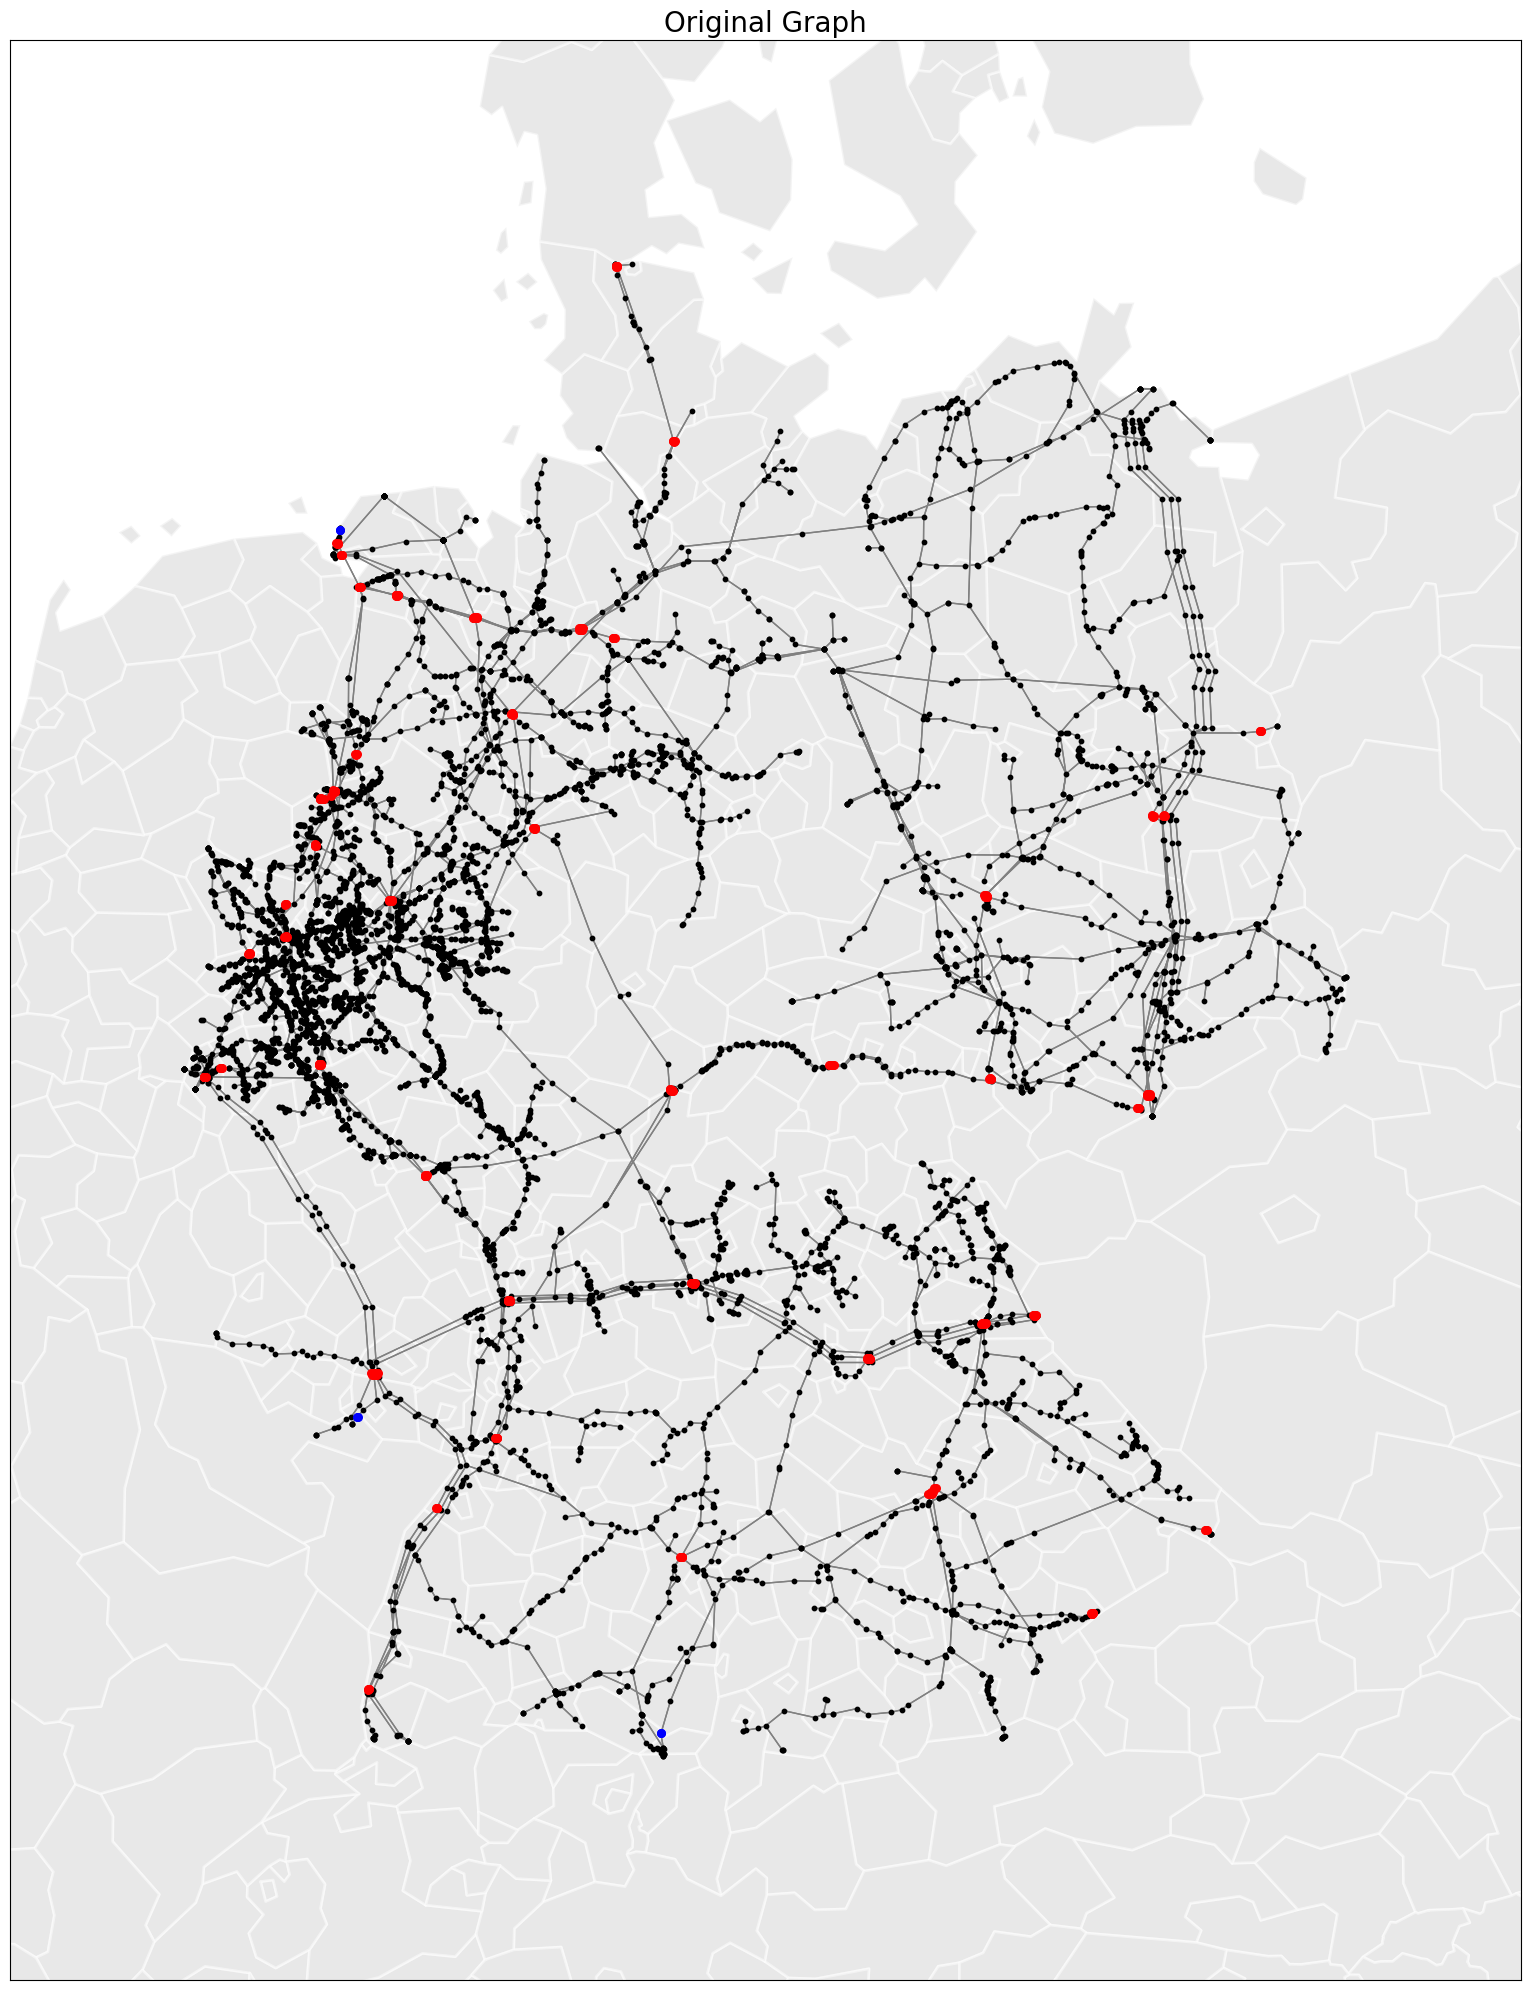

In [37]:
utils.plot_network(
	G=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="Original Graph"
)

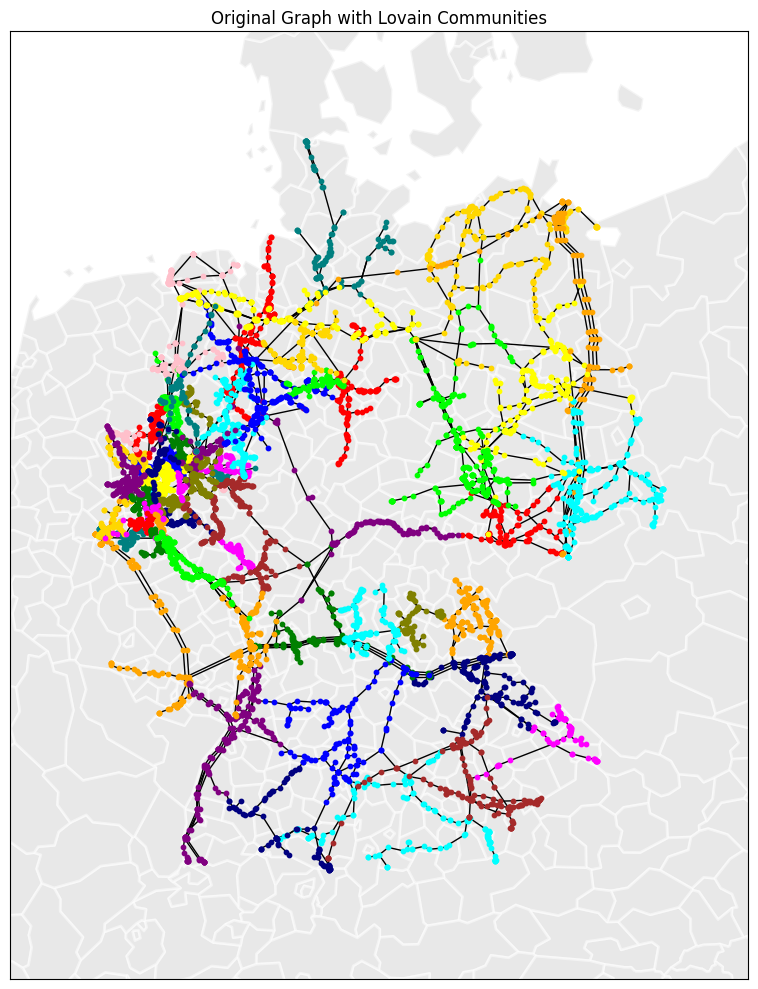

In [ ]:
utils.plot_network(
	graph=original,
	gdf=nuts3.to_crs("EPSG:3035"),
	clusters=louvain_results,
	node_size=10, 
	title="Original Graph with Lovain Communities"
)

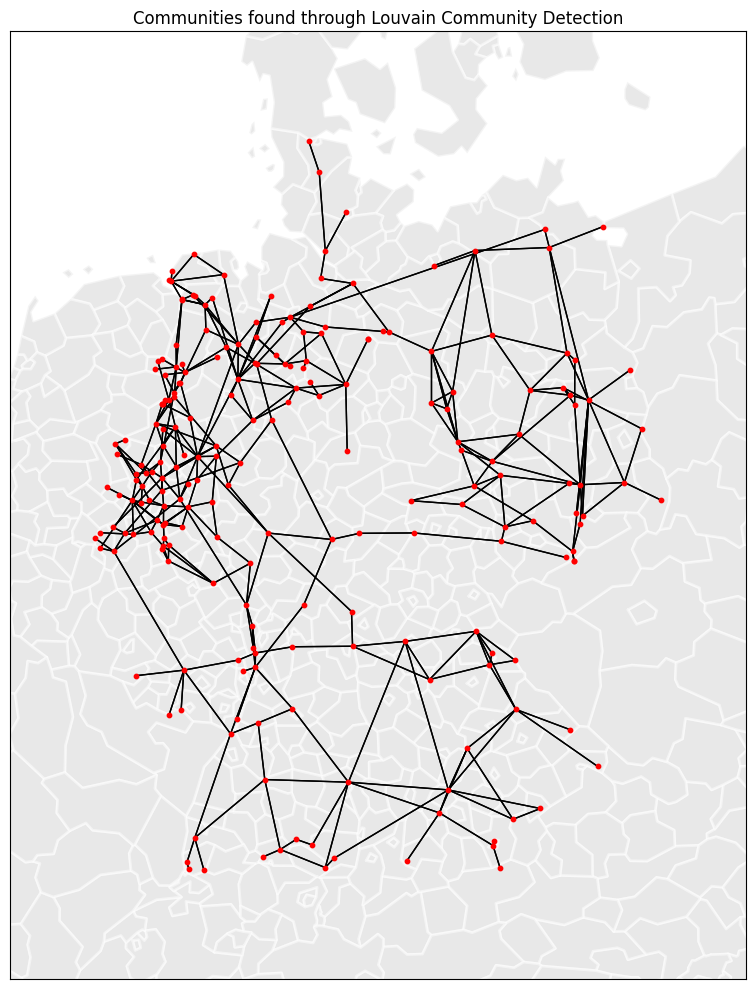

In [ ]:
utils.plot_network(
	graph=louvain_graph,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="Communities found through Louvain Community Detection"
)

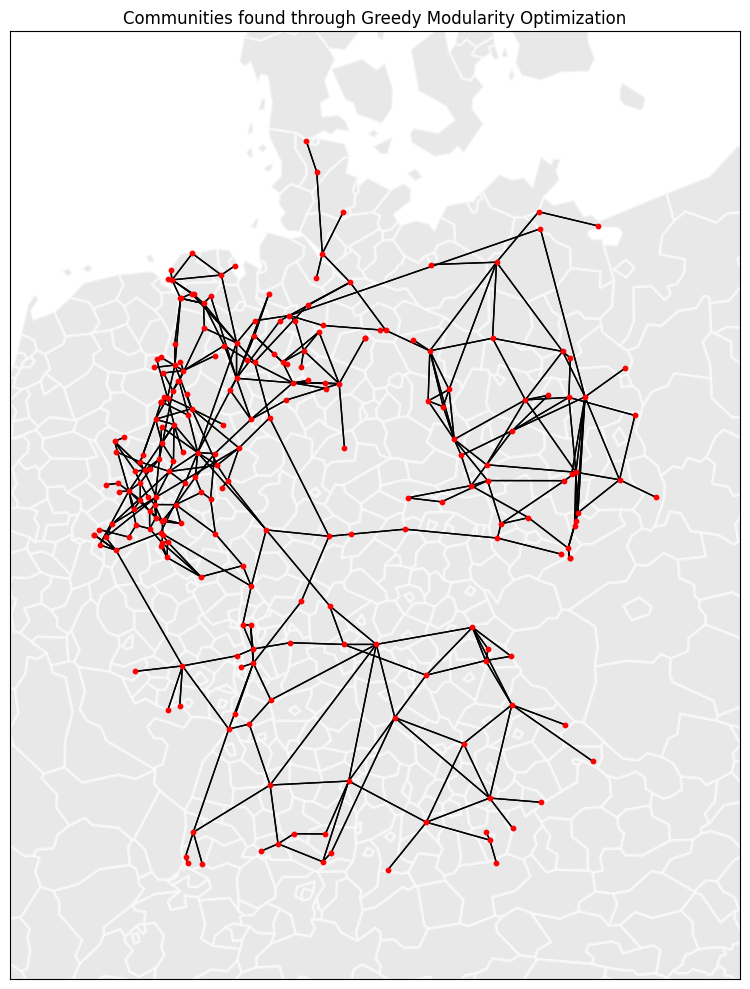

In [148]:
utils.plot_network(
	graph=greedy_modularity_graph,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="Communities found through Greedy Modularity Optimization"
)

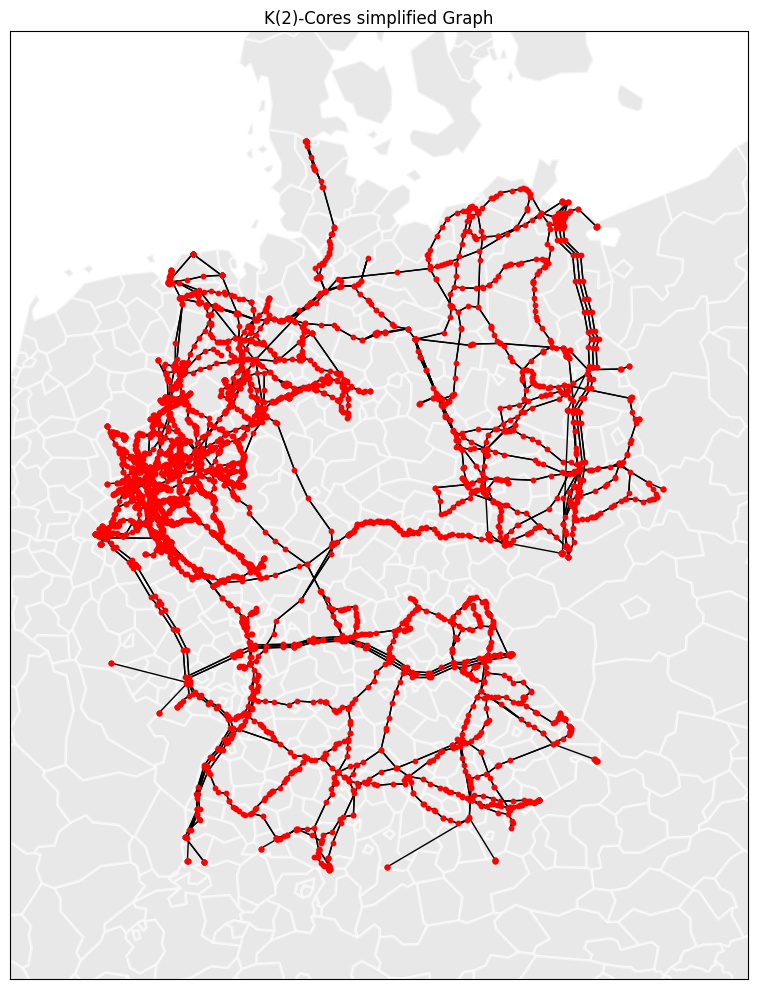

In [122]:
utils.plot_network(
	graph=k2_cores,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="K(2)-Cores simplified Graph"
	)

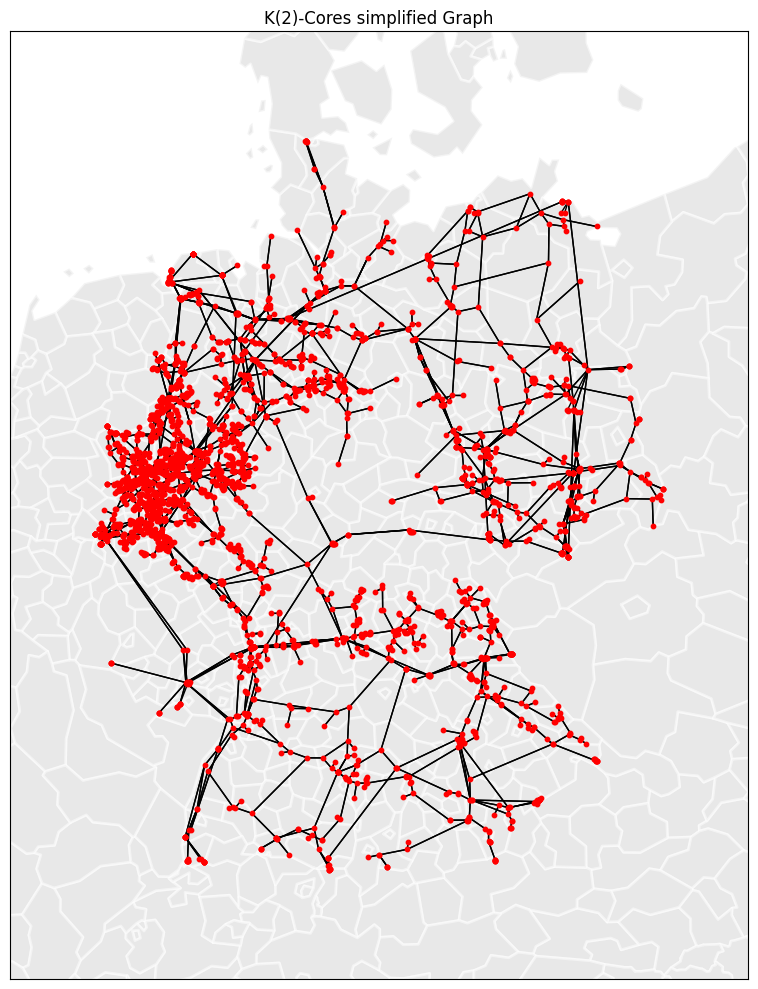

In [285]:
utils.plot_network(
	graph=path_contraction,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="K(2)-Cores simplified Graph"
	)

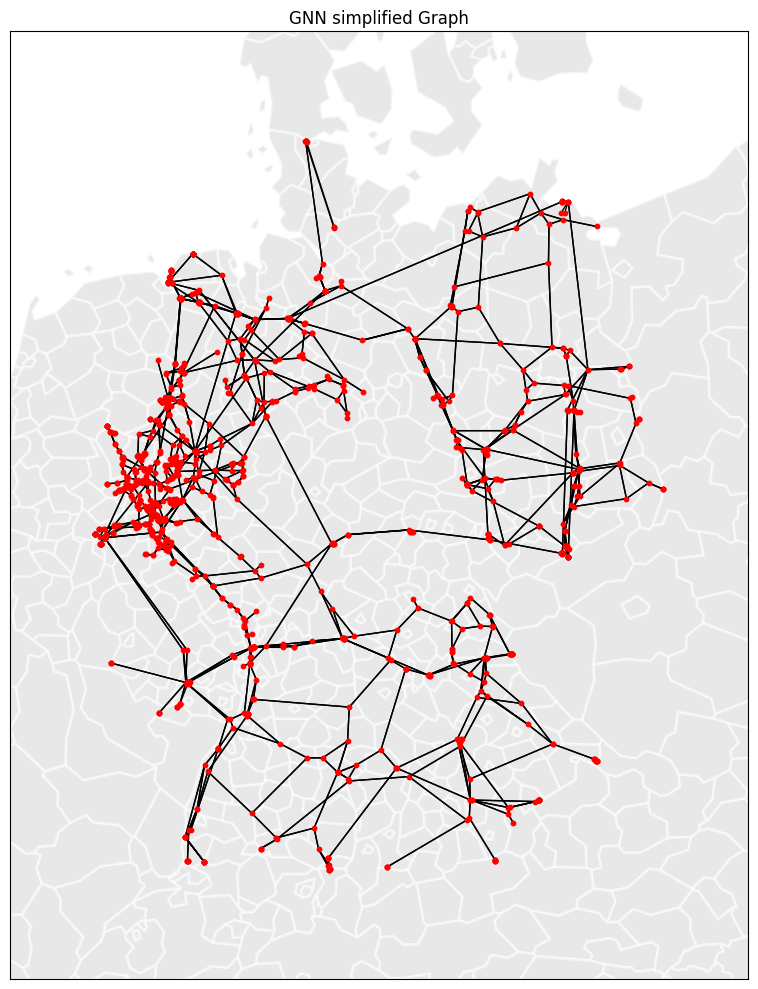

In [125]:
utils.plot_network(
	graph=path_contraction_2,
	gdf=nuts3.to_crs("EPSG:3035"),
	node_size=10, 
	title="GNN simplified Graph"
	)

# Test

In [ ]:
G = nx.read_gml("./data/de2025_simp.gml")

nodes = utils.graph_to_nodes_df(G)

In [ ]:
for node in enumerate(nodes):
		print(node)

(0, 'nodes')
(1, 'coord')
(2, 'node_type')


In [ ]:
k2_cores.nodes(data=True)

NodeDataView({'DSO_2165': {'coord': [4453548.157409, 3008771.494488], 'node_type': 'NO', 'x': 4453548.157409, 'y': 3008771.494488, 'geometry': <POINT (11.856 50.176)>, 'supply': -50.0}, 'DSO_1874': {'coord': [4456175.99051, 3012225.122382], 'node_type': 'NO', 'x': 4456175.99051, 'y': 3012225.122382, 'geometry': <POINT (11.894 50.207)>, 'supply': -50.0}, 'DSO_1870': {'coord': [4457384.46608, 3015160.098374], 'node_type': 'NO', 'x': 4457384.46608, 'y': 3015160.098374, 'geometry': <POINT (11.912 50.233)>, 'supply': -50.0}, 'X_1695': {'coord': [4478892.919205, 2996175.444245], 'node_type': 'NO', 'x': 4478892.919205, 'y': 2996175.444245, 'geometry': <POINT (12.205 50.057)>, 'supply': 0.0}, 'IND_0406': {'coord': [4476909.114047, 2998117.244073], 'node_type': 'NO', 'x': 4476909.114047, 'y': 2998117.244073, 'geometry': <POINT (12.178 50.075)>, 'supply': -50.0}, 'DSO_1866': {'coord': [4478486.128122, 2996876.176661], 'node_type': 'NO', 'x': 4478486.128122, 'y': 2996876.176661, 'geometry': <POIN

In [ ]:
nodes = [(node, data) for node, data in original.nodes(data=True) if node.startswith("CS")]
nodes

[('CS33-NY-01',
  {'coord': [4152024.670518, 3177329.118805],
   'node_type': 'NO',
   'x': 4152024.670518,
   'y': 3177329.118805,
   'geometry': <POINT (7.556 51.681)>,
   'supply': 0.0}),
 ('CS33-NY-00',
  {'coord': [4151884.304059, 3177738.395262],
   'node_type': 'NO',
   'x': 4151884.304059,
   'y': 3177738.395262,
   'geometry': <POINT (7.554 51.685)>,
   'supply': 0.0}),
 ('CS33-NY-03',
  {'coord': [4152305.354305, 3177735.192039],
   'node_type': 'NO',
   'x': 4152305.354305,
   'y': 3177735.192039,
   'geometry': <POINT (7.56 51.685)>,
   'supply': 0.0}),
 ('CS21-NY-03',
  {'coord': [4502131.693054, 2952152.87114],
   'node_type': 'NO',
   'x': 4502131.693054,
   'y': 2952152.87114,
   'geometry': <POINT (12.509 49.654)>,
   'supply': 0.0}),
 ('CS12-NY-01',
  {'coord': [4171936.594865, 3028162.03451],
   'node_type': 'NO',
   'x': 4171936.594865,
   'y': 3028162.03451,
   'geometry': <POINT (7.906 50.346)>,
   'supply': 0.0}),
 ('CS17-NY-01',
  {'coord': [4114614.487214, 3088

In [ ]:
degree = [(node, original.degree(node)) for node, data in nodes]
degree

[('CS33-NY-01', 2),
 ('CS33-NY-00', 2),
 ('CS33-NY-03', 2),
 ('CS21-NY-03', 2),
 ('CS12-NY-01', 2),
 ('CS17-NY-01', 2),
 ('CS17-NY-00', 2),
 ('CS22-NY-03', 2),
 ('CS11-NY-02', 2),
 ('CS15-NY-02', 2),
 ('CS04-NY-00', 2),
 ('CS27-CS', 6),
 ('CS33-NY-11', 2),
 ('CS24-CS', 8),
 ('CS25-CS', 8),
 ('CS35-CS', 4),
 ('CS33-NY-10', 2),
 ('CS30-CS', 11),
 ('CS23-CS', 11),
 ('CS29-CS', 8),
 ('CS28-CS', 5),
 ('CS00-CS', 2),
 ('CS04-NY-01', 2),
 ('CS47-CS', 9),
 ('CS02-CS', 2),
 ('CS41-CS', 4),
 ('CS42-CS', 5),
 ('CS38-CS', 9),
 ('CS39-CS', 6),
 ('CS44-CS', 5),
 ('CS43-CS', 2),
 ('CS40-CS', 4),
 ('CS13-CS', 4),
 ('CS11-CS', 3),
 ('CS22-CS', 9),
 ('CS18-CS', 7),
 ('CS15-CS', 3),
 ('CS05-CS', 2),
 ('CS16-CS', 7),
 ('CS04-CS', 2),
 ('CS20-CS', 2),
 ('CS26-CS', 4),
 ('CS31-CS', 4),
 ('CS34-CS', 6),
 ('CS16-NY-01', 2),
 ('CS36-CS', 9),
 ('CS14-CS', 2),
 ('CS19-CS', 6),
 ('CS07-CS', 5),
 ('CS03-CS', 2),
 ('CS16-NY-06', 2),
 ('CS08-CS', 2),
 ('CS10-CS', 2),
 ('CS32-CS', 11),
 ('CS09-CS', 2),
 ('CS48-CS', 5

In [ ]:
k2_cores_sim.res_compressor.reset_index(drop=True)

deltap_bar  p_from_bar  p_to_bar  t_from_k  t_to_k  t_outlet_k  \
0         NaN         NaN       NaN       NaN     NaN         NaN   
1         NaN         NaN       NaN       NaN     NaN         NaN   
2         NaN         NaN       NaN       NaN     NaN         NaN   

   mdot_from_kg_per_s  mdot_to_kg_per_s  vdot_norm_m3_per_s  normfactor_from  \
0                 NaN               NaN                 NaN              NaN   
1                 NaN               NaN                 NaN              NaN   
2                 NaN               NaN                 NaN              NaN   

   normfactor_to  compr_power_mw  
0            NaN             NaN  
1            NaN             NaN  
2            NaN             NaN

In [ ]:
original.nodes(data=True)

NodeDataView({'X_1693': {'coord': [4451976.104649, 3022833.492192], 'node_type': 'NO', 'x': 4451976.104649, 'y': 3022833.492192, 'geometry': <POINT (11.838 50.303)>, 'supply': 0.0}, 'DSO_1871': {'coord': [4454335.933506, 3018632.118088], 'node_type': 'NO', 'x': 4454335.933506, 'y': 3018632.118088, 'geometry': <POINT (11.87 50.265)>, 'supply': -0.0}, 'DSO_2165': {'coord': [4453548.157409, 3008771.494488], 'node_type': 'NO', 'x': 4453548.157409, 'y': 3008771.494488, 'geometry': <POINT (11.856 50.176)>, 'supply': -0.36556566480905966}, 'DSO_1874': {'coord': [4456175.99051, 3012225.122382], 'node_type': 'NO', 'x': 4456175.99051, 'y': 3012225.122382, 'geometry': <POINT (11.894 50.207)>, 'supply': -0.8889832929166654}, 'DSO_1870': {'coord': [4457384.46608, 3015160.098374], 'node_type': 'NO', 'x': 4457384.46608, 'y': 3015160.098374, 'geometry': <POINT (11.912 50.233)>, 'supply': -0.302730630832476}, 'DSO_1869': {'coord': [4457512.658531, 3015251.232525], 'node_type': 'NO', 'x': 4457512.658531

In [ ]:
original.to_undirected()

In [ ]:
k2_cores

In [35]:
for simp_node, simp_data in greedy_modularity_graph.nodes(data=True):
    total_cluster_supply = 0
    # Look inside the cluster to find the original nodes
    for orig_node_id in simp_data['original_nodes']:
        # Get the supply value from the original graph's node
        total_cluster_supply += original.nodes[orig_node_id].get('supply', 0)
    
    # Assign the summed value to the cluster node
    simp_data['supply'] = total_cluster_supply


In [60]:
gpd.GeoDataFrame(utils.graph_to_nodes_df(original))

nodes                             coord node_type    supply
0       X_1693  [4451976.104649, 3022833.492192]        NO  0.000000
1     DSO_1871  [4454335.933506, 3018632.118088]        NO -0.044353
2     DSO_2165  [4453548.157409, 3008771.494488]        NO -0.228967
3     DSO_1874   [4456175.99051, 3012225.122382]        NO -0.513222
4     DSO_1870   [4457384.46608, 3015160.098374]        NO -0.328399
...        ...                               ...       ...       ...
7891    X_2517  [4235987.502898, 3416046.023697]        NO  0.000000
7892    X_2527   [4128939.161654, 3055842.00448]        NO  0.000000
7893    X_2526  [4128937.560941, 3055833.157972]        NO  0.000000
7894  DSO_2575  [4126570.937362, 3058268.010563]        NO -0.153558
7895    X_2529   [4128933.678084, 3055843.20956]        NO  0.000000

[7896 rows x 4 columns]

In [304]:
k2_cores.nodes(data=True)

NodeDataView({'DSO_2165': {'coord': [4453548.157409, 3008771.494488], 'node_type': 'NO', 'supply': -0.9184225243809383}, 'DSO_1874': {'coord': [4456175.99051, 3012225.122382], 'node_type': 'NO', 'supply': -0.8463315697372134}, 'DSO_1870': {'coord': [4457384.46608, 3015160.098374], 'node_type': 'NO', 'supply': -1.2996401162537927}, 'X_1695': {'coord': [4478892.919205, 2996175.444245], 'node_type': 'NO', 'supply': 0.0}, 'IND_0406': {'coord': [4476909.114047, 2998117.244073], 'node_type': 'NO', 'supply': -0.303501132169006}, 'DSO_1866': {'coord': [4478486.128122, 2996876.176661], 'node_type': 'NO', 'supply': -0.3036034102970447}, 'DSO_1867': {'coord': [4478420.694777, 2996927.961215], 'node_type': 'NO', 'supply': -0.30352870433693263}, 'DSO_2390': {'coord': [4145230.360283, 3161410.029485], 'node_type': 'NO', 'supply': -2.6221910046723624}, 'X_1697': {'coord': [4136919.353905, 3165120.146394], 'node_type': 'NO', 'supply': 0.0}, 'X_1694': {'coord': [4136550.182275, 3165925.591494], 'node_t

In [157]:
len(original.edges())

17310

In [156]:
len(original.nodes())

7896

In [155]:
len(mst.edges())

7895

In [89]:
path_contraction.edges(data=True)

OutEdgeDataView([('DSO_2627', 'X_2984', {'L': 1.119, 'DN': 200.0, 'Pmax': 100.0, 'capacity': 8.58636910976685, 'norm_capacity': 0.016859704440062857}), ('CS19-NY-03', 'CS19-CS-IN', {'L': 0.01, 'DN': 1200, 'Pmax': 120, 'capacity': 877.3255825298124, 'norm_capacity': 0.7455473095296218}), ('CS19-NY-03', 'CS19-CS-OUT', {'L': 0.01, 'DN': 1200, 'Pmax': 120, 'capacity': 877.3255825298124, 'norm_capacity': 0.7455473095296218}), ('CS19-NY-03', 'X_0793', {'edge_name': 'X_0793^CS19-NY-03_contracted', 'edge_type': 'pipe_contracted', 'L': 48.458, 'Pmax': 100.0, 'DN': 300.0, 'capacity': 23.365048477374696, 'norm_capacity': 0.029255876166182096}), ('IC_AT06-IN', 'CS35-NY-02', {'edge_name': 'CS35-NY-02^IC_AT06-IN_contracted', 'edge_type': 'pipe_contracted', 'L': 0.099, 'Pmax': 100.0, 'DN': 700.0, 'capacity': 204.422061593112, 'norm_capacity': 0.1811242380795102}), ('IND_0254', 'DSO_2819', {'L': 7.154, 'DN': 400.0, 'Pmax': 100.0, 'capacity': 49.43940021740342, 'norm_capacity': 0.05112671683988098}), (